In [17]:
import sys
sys.path.insert(0, '/home/gfzg/workspace/数据下载/Wind/Packages')
sys.path.insert(0, '/home/gfzg/workspace/债券分析/Packages')
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings
from importlib import reload
import re
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import math
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import janitor
import time
from progressbar import progressbar as pbar # 该用pg进度条了
from tabulate import tabulate
# 核心包
import Wind
import Bonder
import Selector
import dolphindb as ddb

import matplotlib as mpl
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

### 字段说明

In [ ]:
# 可供筛选字段与选项
# {'S_INFO_WINDCODE': '债券代码',
#  'B_INFO_FULLNAME': '债券名',
#  'B_INFO_ISSUER': '债券发行主体',
#  'B_INFO_CARRYDATE': '起息日',
#  'B_INFO_MATURITYDATE': '到期日',
#  'B_INFO_TERM_YEAR_': '未调整期限',
#  'B_INFO_PAYMENTTYPE': '计息方式',                       '单利', '复利'
#  'S_INFO_EXCHMARKET': '交易所',                          'NIB', 'SSE', 'SZSE'
#  'B_INFO_INTERESTFREQUENCY': '计息频率',                 '每3月', '每1月', '每1年', '每9月', '每6月', '每4月', '每15天', '每2月'
#  'B_INFO_ISSUERCODE': '发行主体代码',
#  'IS_CORPORATE_BOND': '是否公司债',                       0,1
#  'B_INFO_ISSUERTYPE': '发行主体类型',                     '企业', '其它金融机构', '股份制商业银行', '国有商业银行', '城市商业银行', '证券公司', '政策性银行', '地方政府', '财政部', '国际机构', '中国人民银行'
#  'B_INFO_ISSUETYPE': '发行方式',                         '公募', '私募', '优先配售和上网定价', '优先配售，网上定价和网下配售', '上网定价', '定向','上网定价和网下配售', '优先配售，网下配售', '包销团包销', '优先配售，定向配售和网上定价', '公开发行','网上发行', '网下发行', '贴现发行', '平价发行'
#  'S_INFO_INDUSTRYNAME_WindLevel1': '债券Wind一级分类',    '短期融资券', '公司债', '中期票据', '可转债', '同业存单', '金融债', '标准化票据', '资产支持证券','定向工具', '企业债', '可分离转债存债', '可交换债', '地方政府债', '国际机构债', '项目收益票据','政府支持机构债', '国债', '央行票据'
#  'S_INFO_INDUSTRYNAME_WindLevel2': '债券Wind二级分类',    '超短期融资债券', '一般公司债', '一般中期票据', '一般短期融资券', '私募债', '商业银行债','商业银行次级债券', '证监会主管ABS', '证券公司债', '一般企业债', '交易商协会ABN', '银保监会主管ABS','证券公司短期融资券', '集合企业债', '其它金融机构债', '保险公司债', '政策银行债', '集合票据'
#  'CATEGORY1': 'GF一级分类',                              '信用债', '可转债', '同业存单', 'ABS', '利率债'
#  'CATEGORY2': 'GF二级分类',                               '超短期融资债券', '公司债', '中期票据', '短期融资券', '可转债', '同业存单', '金融债', '其他','ABS', '定向工具', '企业债', '可分离转债存债', '可交换债', '地方政府债', '政策银行债','政府支持机构债', '国债', '央行票据'
#  'CATEGORY3': 'GF三级分类',                               '商业银行债', '商业银行次级债券', '证监会主管ABS', '证券公司债', '其它金融机构债','交易商协会ABN', '银保监会主管ABS', '证券公司短期融资券', '保险公司债'
#  'isPerpetualBonds': '是否永续债',                        0,1
#  'isTier2CapitalBonds': '是否次级资本债',                  0,1
#  'BOND_TYPE': '城投产业金融债',                            '产业债', '城投债', '金融债'
#  'B_AGENCY_GUARANTORNATURE': '公司属性',                  '地方国有企业', '公众企业', '民营企业', '中央国有企业', '外资企业', '集体企业', '其他企业','中外合资企业', '外商独资企业', None, nan, '国有企业'
#  'S_INFO_COMPIND_NAME1': '债券主体公司所属Wind一级行业名称',  '公用事业', '工业', '房地产', '可选消费', '材料', '医疗保健', '日常消费', '信息技术', '能源','金融', '电信服务'
#  'S_INFO_COMPIND_NAME2': '债券主体公司所属Wind二级行业名称',   '公用事业Ⅱ', '资本货物', '房地产Ⅱ', '汽车与汽车零部件', '材料Ⅱ', '运输', '商业和专业服务','医疗保健设备与服务', '食品与主要用品零售Ⅱ', '媒体Ⅱ', '制药、生物科技与生命科学', '消费者服务Ⅱ','食品、饮料与烟草', '零售业', '技术硬件与设备', '能源Ⅱ', '多元金融', '耐用消费品与服装', '家庭与个人用品','半导体与半导体生产设备', '软件与服务', '电信服务Ⅱ', '银行', '保险Ⅱ'
#  'S_INFO_COMPIND_NAME3': '债券主体公司所属Wind三级行业名称',  '水务Ⅲ', '贸易公司与工业品经销商Ⅲ', '机械', '建筑与工程Ⅲ', '房地产管理和开发', '电力Ⅲ', '汽车','金属、非金属与采矿', '交通基础设施', '综合类Ⅲ', '纸与林木产品', '商业服务与用品', '医疗保健提供商与服务','食品与主要用品零售Ⅲ', '媒体Ⅲ', '化工', '制药', '酒店、餐馆与休闲Ⅲ', '容器与包装', '专业服务','建材Ⅲ', '复合型公用事业Ⅲ', '燃气Ⅲ', '航空货运与物流Ⅲ', '食品', '饮料', '多元化零售','公路与铁路运输', '电子设备、仪器和元件', '通信设备Ⅲ', '汽车零配件', '石油、天然气与供消费用燃料','多元金融服务', '专营零售', '纺织品、服装与奢侈品', '航空Ⅲ', '独立电力生产商与能源贸易商Ⅲ', '电气设备','个人用品Ⅲ', '航空航天与国防Ⅲ', '建筑产品Ⅲ', '半导体产品与半导体设备', '海运Ⅲ', '家庭耐用消费品','消费品经销商Ⅲ', '信息技术服务', '医疗保健设备与用品', '互联网与售货目录零售', '多元电信服务','互联网软件与服务Ⅲ', '资本市场', '能源设备与服务', '消费信贷Ⅲ', '电脑与外围设备', '软件','医疗保健技术Ⅲ','休闲设备与用品', '生物科技Ⅲ', '家庭用品Ⅲ', '综合消费者服务Ⅲ','股权房地产投资信托(REITs)', '办公电子设备Ⅲ', '互助储蓄银行与抵押信贷Ⅲ', '商业银行','生命科学工具和服务Ⅲ', '保险Ⅲ'
#  'S_INFO_COMPIND_NAME4': '债券主体公司所属Wind四级行业名称',   
       '水务', '贸易公司与工业品经销商', '建筑机械与重型卡车', '建筑与工程', '房地产开发', '电力', '汽车制造',
       '金属非金属', '海港与服务', '工业机械', '综合类行业', '林木产品', '环境与设施服务', '保健护理产品经销商',
       '大卖场与超市', '出版', '公路与铁路', '化肥与农用化工', '西药', '酒店、度假村与豪华游轮', '金属与玻璃容器',
       '调查和咨询服务', '有线和卫星电视', '建材', '复合型公用事业', '燃气', '航空货运与物流', '食品加工与肉类',
       '白酒与葡萄酒', '百货商店', '钢铁', '房地产服务', '铁路运输', '电子元件', '食品分销商',
       '电子设备和仪器', '通信设备', '机动车零配件与设备', '综合支持服务', '综合性石油天然气', '多领域控股',
       '中药', '汽车零售', '服装、服饰与奢侈品', '药品零售', '航空', '黄金', '化纤', '综合货品商店',
       '新能源发电业者', '铝', '煤炭与消费用燃料', '多元化工', '贵金属与矿石', '公路运输', '电气部件与设备',
       '电影与娱乐', '个人用品', '重型电气设备', '农产品', '房地产经营公司', '基础化工', '航天航空与国防',
       '石油与天然气的炼制和销售', '建筑产品', '半导体产品', '海运', '商业印刷', '其他多元金融服务', '食品零售',
       '独立电力生产商与能源贸易商', '家用电器', '特种化工', '啤酒', '鞋类', '石油天然气勘探与生产',
       '人力资源与就业服务', '电子制造服务', '机场服务', '技术产品经销商', '消费电子产品', '消费品经销商',
       '信息科技咨询与其它服务', '铜', '医疗保健用品', '互联网零售', '纺织品', '综合电信服务', '家庭装饰品',
       '互联网软件与服务', '特殊金融服务', '纸制品', '资产管理与托管银行', '石油天然气设备与服务', '消费信贷',
       '电脑与电子产品零售', '多元资本市场', '广告', '保健护理服务', '电脑硬件', '应用软件', '医疗保健技术',
       '工业气体', '医疗保健设备', '家庭装潢零售', '半导体设备', '售货目录零售', '摩托车制造',
       '投资银行业与经纪业', '家庭装饰零售', '石油与天然气的储存和运输', '休闲设施', '电脑存储与外围设备', '纸包装',
       '非传统电信运营商', '休闲用品', '生物科技', '白银', '家庭娱乐软件', '家庭用品', '轮胎与橡胶',
       '教育服务', '特殊消费者服务', '家用器具与特殊消费品', '农用农业机械', '软饮料', '多样化房地产活动',
       '数据处理与外包服务', '石油天然气钻井', '广播', '保健护理设施', '多样化房地产投资信托', '餐馆',
       '工业房地产投资信托', '办公电子设备', '互助储蓄与抵押信贷金融服务', '住宅建筑', '摄影用品', '多元化银行',
       '区域性银行', '生命科学工具和服务', '多元化保险', '人寿与健康保险', '财产与意外伤害保险', '再保险'
#  'TRADE_DT': '交易日期', 
#  'B_ANAL_MATU_CNBD': '剩余期限',
#  'B_ANAL_MATU_CNBD_YEAR': '债券在未来N年内到期',      1,2,3,4,...
#  'B_ANAL_RESIDUALPRI': '债券剩余本金',
#  'CNBD_HIDDEN_CREDITRATING': '债券隐含评级',        'AAA','AA+',...
#  'B_INFO_CREDITRATING_BOND': '债券外部评级',           'AAA','AA+',...
#  'B_INFO_ISSUERCODE': '债券发行主体代码',
#  'B_INFO_CREDITRATING_ISSUER': '债券发行主体外部评级',   'AAA','AA+',...
} 

In [ ]:
##  静态表：城投专有字段
#  'PROVINCE': '省',     '广东省', '河南省', '浙江省', '新疆维吾尔自治区', '江苏省', '湖北省', '四川省', '天津','安徽省', '山东省', '湖南省', '江西省', '山西省', '云南省', '陕西省', '青海省', '福建省','广西壮族自治区', '重庆', '宁夏回族自治区', '上海', '甘肃省', '吉林省', '河北省', '辽宁省', '北京','黑龙江省', '贵州省', '西藏自治区', '海南省', '内蒙古自治区'                             
#  'CITY': '市',
       '中山市', '东莞市', '宁波市', '哈密市', '深圳市', '南京市', '无锡市', '十堰市',
       '成都市', '天津市', '湖州市', '合肥市', '青岛市', '六安市', '台州市', '岳阳市', '衡阳市',
       '连云港市', '镇江市', '苏州市', '萍乡市', '绍兴市', '盐城市', '滁州市', '泰州市', '邵阳市',
       '马鞍山市', '上饶市', '济宁市', '晋中市', '杭州市', '西安市', '焦作市', '武汉市', '西宁市',
       '嘉兴市', '漳州市', '南宁市', '南平市', '徐州市', '潍坊市', '福州市', '重庆市', '常州市',
       '铜陵市', '珠海市', '银川市', '平顶山市', '淄博市', '随州市', '乌鲁木齐市', '南昌市', '济源市',
       '上海市', '广州市', '荆门市', '运城市', '亳州市', '巴音郭楞蒙古自治州', '南通市', '第十二师',
       '淮北市', '泉州市', '昆明市', '郑州市', '广安市', '太原市', '吉林市', '榆林市', '滨州市',
       '邯郸市', '锦州市', '淮安市', '扬州市', '龙岩市', '温州市', '株洲市', '黄石市', '宿迁市',
       '湘潭市', '厦门市', '钦州市', '长春市', '长沙市', '伊犁哈萨克自治州', '信阳市', '泰安市', '柳州市',
       '烟台市', '益阳市', '遂宁市', '永州市', '唐山市', '怀化市', '桂林市', '巴中市', '北京市',
       '赣州市', '佛山市', '乐山市', '常德市', '开封市', '金华市', '第七师', '兰州市', '哈尔滨市',
       '宜昌市', '大连市', '景德镇市', '济南市', '鹰潭市', '第八师', '驻马店市', '宣城市', '吉安市',
       '洛阳市', '绵阳市', '宁德市', '雄安新区', '漯河市', '阜阳市', '第六师', '第一师', '南阳市',
       '衢州市', '拉萨市', '日照市', '舟山市', '临沂市', '德阳市', '安庆市', '三明市',
       '博尔塔拉蒙古自治州', '咸阳市', '商丘市', '蚌埠市', '牡丹江市', '淮南市', '第二师', '黄山市',
       '芜湖市', '宿州市', '襄阳市', '抚州市', '宜春市', '第四师', '濮阳市', '渭南市', '克拉玛依市',
       '三门峡市', '孝感市', '周口市', '自贡市', '许昌市', '广元市', '石家庄市', '荆州市', '邢台市',
       '宝鸡市', '湛江市', '沈阳市', '宜宾市', '贵阳市', '泸州市', '遵义市', '池州市', '江门市',
       '眉山市', '惠州市', '杨凌示范区', '德州市', '铁岭市', '凉山彝族自治州', '聊城市', '秦皇岛市',
       '东营市', '达州市', '长治市', '昌吉回族自治州', '鄂尔多斯市', '攀枝花市', '辽源市', '郴州市',
       '娄底市', '汉中市', '枣庄市', '安阳市', '大庆市', '张家界市', '张家口市', '包头市', '鸡西市',
       '营口市', '咸宁市', '九江市', '阳江市', '新乡市', '威海市', '汕头市', '南充市',
       '伊犁哈萨克自治州塔城地区', '张掖市', '来宾市', '晋城市', '湘西土家族苗族自治州', '第十师', '丽水市',
       '黄冈市', '六盘水市', '肇庆市', '沧州市', '雅安市', '清远市', '北海市', '阿克苏地区', '菏泽市',
       '鹤壁市', '新余市', '资阳市', '武威市', '莆田市', '延安市', '临汾市', '鄂州市', '崇左市',
       '铜仁市', '玉林市', '安康市', '三亚市', '鞍山市', '赤峰市', '延边朝鲜族自治州', '本溪市', '铜川市',
       '梧州市', '百色市', '松原市', '商洛市', '葫芦岛市', '通辽市', '吐鲁番市', '西双版纳傣族自治州',
       '忻州市', '文山壮族苗族自治州', '安顺市', '呼伦贝尔市', '黔南布依族苗族自治州', '河源市', '双鸭山市',
       '内江市', '毕节市', '曲靖市', '黔西南布依族苗族自治州', '黔东南苗族侗族自治州', '红河哈尼族彝族自治州',
       '廊坊市', '玉溪市', '保山市', '平凉市', '河池市', '梅州市', '承德市', '防城港市', '普洱市',
       '盘锦市', '大同市', '德宏傣族景颇族自治州', '汕尾市', '大理白族自治州', '贵港市', '赣江新区', '衡水市',
       '保定市', '楚雄彝族自治州', '定西市', '白银市', '仙桃市', '抚顺市', '辽阳市', '潜江市',
       '呼和浩特市', '四平市', '伊春市', '佳木斯市', '锡林郭勒盟', '绥化市', '通化市', '齐齐哈尔市',
       '白山市', '丽江市', '鹤岗市', '巴彦淖尔市', '临沧市', '黑河市', '朝阳市', '丹东市', '酒泉市',
       '庆阳市', '贺州市', '伊犁哈萨克自治州阿勒泰地区', '乌兰察布市', '海东市', '茂名市', '阿拉善盟',
       '云浮市', '天门市', '嘉峪关市', '克孜勒苏柯尔克孜自治州', '金昌市', '吴忠市', '恩施土家族苗族自治州',
       '乌海市', '白城市', '喀什地区', '海西蒙古族藏族自治州', '韶关市', '七台河市', '阜新市', '和田地区',
       '揭阳市', '朔州市', '兴安盟', '中卫市'
#  'DISTRICT': '区',
       '福田区', '栖霞区', '丹江口市', '滨海新区', '温岭市', '蜀山区', '连云区',
       '太仓市', '亭湖区', '靖江市', '邹城市', '雁塔区', '南湖区', '昆山市', '江宁区', '丹阳市',
       '合川区', '武清区', '泰兴市', '溧阳市', '张家港市', '双流区', '虎丘区', '涪陵区', '相城区',
       '新市区', '建邺区', '浦东新区', '黄埔区', '江北新区浦口区', '广信区', '椒江区', '吴江区',
       '库尔勒市', '嘉善县', '萧山区', '如皋市', '巢湖市', '滨湖区', '长兴县', '海宁市', '江阴市',
       '广安区', '赣榆区', '晋江市', '寒亭区', '越城区滨海新区', '路桥区', '钱塘区', '綦江区', '黄浦区',
       '两江新区', '宝坻区', '海盐县', '郫都区', '岳塘区', '沙坪坝区', '海沧区', '钦南区', '天元区',
       '雨花区', '伊宁市', '宜兴市', '金坛区', '海曙区', '长寿区', '海安市', '雨湖区', '湘江新区岳麓区',
       '江津区', '津南区', '临桂新区', '永川区', '溧水区', '通州区', '海淀区', '鱼峰区', '胶州市',
       '鄞州区', '吴中区', '邗江区', '常熟市', '滇中新区', '临湘市', '禅城区', '柯桥区', '望城区',
       '海门区', '掇刀区', '玄武区', '龙亭区', '义乌市', '西青区', '锡山区', '慈溪市', '高邮市',
       '西陵区', '兖州区', '西海岸新区', '天心区', '江北新区六合区', '历下区', '安源区', '永康市',
       '五华区', '浏阳市', '武进区', '巴南区', '吉安县', '宁乡市', '洛龙区', '青白江区', '奉化区',
       '城南新区', '涪城区', '秀洲区', '上虞区', '莱西市', '即墨区', '温江区', '大兴区', '蓟州区',
       '肥西县', '余姚市', '城阳区', '京山市', '高淳区', '闵行区', '钟楼区', '李沧区', '横琴新区',
       '大足区', '海州区', '下城区', '新都区', '阎良区', '旌阳区', '静安区', '宜秀区', '章贡区',
       '芙蓉区', '九龙坡区', '淮阴区', '番禺区', '静海区', '禹会区', '涟水县', '江岸区', '兴化市',
       '天宁区', '盐都区', '彭州市', '西城区', '镇海区', '江南区', '崇川区', '龙海区', '灞桥区',
       '铜山区', '南岸区', '仪征市', '江北新区', '建德市', '南海区', '清江浦区', '顺义区', '平湖市',
       '武侯区', '大丰区', '洪山区', '富阳区', '开福区', '宁国市', '北碚区', '南浔区', '黔江区',
       '黄陂区', '桐乡市', '崂山区', '松江区', '新北区', '惠山区', '广陵区', '奉节县', '姑苏区',
       '福州新区', '瑶海区', '市北区', '雨花台区', '宿城区', '姜堰区', '北辰区', '成华区', '德清县',
       '象山县', '石狮市', '婺城区', '顺德区', '南沙区', '万州区', '兰山区', '宁海县', '开州区',
       '龙泉驿区', '昌平区', '青山湖区', '阳新县', '南安市', '淮安区', '西乡塘区', '上城区', '建湖县',
       '思明区', '琅琊区', '弋江区', '西湖区', '余杭区', '平度市', '新郑市', '东西湖区', '两江新区渝北区',
       '庄河市', '江都区', '海陵区', '湘江新区', '北仑区', '神木市', '嵊州市', '江油市', '宽城区',
       '上杭县', '宁阳县', '普陀区', '桐庐县', '诸暨市', '长沙县', '曹妃甸区', '天府新区', '朝阳区',
       '未央区', '启东市', '金普新区', '仁寿县', '安吉县', '江阳区', '奉贤区', '金牛区', '长春新区',
       '贵安新区', '临安区', '邹平市', '滕州市', '平谷区', '郑州新区', '嘉定区', '红谷滩新区', '乐清市',
       '路南区', '邳州市', '新吴区', '巩义市', '东至县', '吴兴区', '锦江区', '东台市', '长安区',
       '两江新区江北区', '赫山区', '潼南区', '福山区', '金堂县', '咸安区', '原阳县', '江海区', '扬中市',
       '新沂市', '环翠区', '孝南区', '丰城市', '蔡甸区', '东海县', '义安区', '临淄区', '渝中区',
       '滨湖新区', '密云区', '花山区', '雁峰区', '苍南县', '中原区', '奎屯市', '西咸新区', '宜都市',
       '吉首市', '丰县', '铜梁区', '袁州区', '闽侯县', '灌云县', '沛县', '都江堰市', '正定县',
       '梁溪区', '平阳县', '瑞安市', '贾汪区', '高港区', '荣昌区', '黄骅市', '简阳市', '怀柔区',
       '硚口区', '文登区', '新津区', '武隆区', '拱墅区', '寿光市', '江汉区', '雨山区', '淳安县',
       '龙马潭区', '翠屏区', '丰都县', '大渡口区', '荥阳市', '丰台区', '邛崃市', '崇州市', '江夏区',
       '鸠江区', '管城回族区', '齐河县', '金山区', '东昌府区', '宜城市', '雁江区', '灌南县', '湖里区',
       '睢宁县', '青羊区', '蒙城县', '濂溪区', '延安新区', '岳阳楼区', '酉阳土家族苗族自治县', '东港区',
       '任城区', '武陵源区', '庐江县', '滨海县', '奎文区', '月湖区', '句容市', '南川区', '福清市',
       '武陵区', '云龙区', '建阳区', '乳山市', '龙湾区', '仙居县', '苏仙区', '张店区',
       '荆州纪南生态文化旅游区', '延庆区', '长宁区', '岱岳区', '宿豫区', '云溪区', '河东区', '章贡区蓉江新区',
       '娄星区', '京口区', '滨城区', '东丽区', '肥东县', '石景山区', '鹤城区', '坪山区', '璧山区',
       '沙市区', '宣州区', '开化县', '瓦房店市', '新泰市', '滨江区', '三门县', '准格尔旗', '沭阳县',
       '广德市', '阿克苏市', '平潭县', '越城区', '金湖县', '广汉市', '新昌县', '湘乡市', '蓬江区',
       '扎鲁特旗', '如东县', '新密市', '府谷县', '宁安市', '林州市', '桓台县', '景洪市', '定海区',
       '宁河区', '贵池区', '盱眙县', '渝水区', '仁怀市', '兰州新区', '郎溪县', '扎兰屯市', '泗阳县',
       '西秀区', '福安市', '芦淞区', '鹿城区', '纳溪区', '德兴市', '惠安县', '中牟县', '三水区',
       '源城区', '伊川县', '邵东市', '丹徒区', '博兴县', '四会市', '道县', '石柱土家族自治县', '东兴区',
       '汝州市', '平江县', '新会区', '市中区', '响水县', '七星关区', '钟山区', '汨罗市', '任丘市',
       '麒麟区', '都匀市', '纳雍县', '海城市', '湘阴县', '阜宁县', '西山区', '资溪县', '兴仁市',
       '枝江市', '醴陵市', '船山区', '水城区', '禹州市', '汇川区', '赫章县', '瑞昌市', '大观区',
       '永兴县', '曾都区', '夷陵区', '广丰区', '金沙县', '射阳县', '彭水苗族土家族自治县', '昌吉市',
       '普定县', '埇桥区', '德庆县', '古蔺县', '江北区', '镇远县', '东城区', '西充县', '当涂县',
       '沅江市', '颍上县', '建水县', '松滋市', '博山区', '登封市', '垫江县', '兰考县', '玉环市',
       '黄岩区', '萧县', '明光市', '红花岗区', '青州市', '乌当区', '腾冲市', '盘州市', '龙口市',
       '鄱阳县', '秀山土家族苗族自治县', '丰满区', '云阳县', '南县', '高密市', '荣成市', '岱山县',
       '华容县', '泸县', '来安县', '南谯区', '鼎城区', '兰陵县', '洪泽区', '洞头区', '伊州区',
       '红塔区', '钟祥市', '西工区', '义龙新区', '瓯海区', '上街区', '泉港区', '鹤山市', '彭山区',
       '潍城区', '博望区', '潜山市', '涧西区', '南部新区', '薛城区', '肥城市', '石门县', '灵璧县',
       '右江区', '永嘉县', '赤水市', '城口县', '青山区', '湄潭县', '五家渠市', '峨眉山市', '谯城区',
       '安仁县', '安溪县', '利辛县', '彭泽县', '和平区', '南康区', '和县', '东坡区', '太和县',
       '什邡市', '花溪区', '清镇市', '莲都区', '汝城县', '韩城市', '淄川区', '兴隆台区', '岑巩县',
       '碧江区', '定南县', '杨浦区', '宝塔区', '凯里市', '瓮安县', '合江县', '永定区', '瑞丽市',
       '播州区', '嵩明县', '桃源县', '沙河口区', '大理市', '乐亭县', '冷水滩区', '新蒲新区', '长顺县',
       '孟津县', '大冶市', '独山县', '太白湖区', '郓城县', '湖口县', '南明区', '天台县', '睢阳区',
       '惠水县', '碑林区', '兰溪市', '天长市', '老城区', '西峡县', '钢城区', '金东区', '浦江县',
       '陕州区', '新安县', '东乡区', '玉屏侗族自治县', '泗洪县', '铅山县', '临颍县', '新罗区', '安远县',
       '忠县', '宝丰县', '桐城市', '仙游县', '樊城区', '柴桑区', '怀远县', '莲湖区', '金安区',
       '缙云县', '龙游县', '安龙县', '嘉禾县', '柯城区', '高明区', '泰顺县', '辉县市', '芝罘区',
       '霍山县', '新建区', '万秀区', '江山市', '遂昌县', '高要区', '历城区', '大邑县', '金湾区',
       '兴国县', '微山县', '台山市', '嵊泗县', '关岭布依族苗族自治县', '弥勒市', '绵竹市', '诸城市',
       '杜集区', '章丘区', '常山县', '安丘市', '武义县', '宁津县', '东阳市', '晋宁区', '襄州区',
       '渠县', '岚山区', '浮梁县', '周村区', '衢江区', '宣汉县', '弋阳县', '万载县', '长宁县',
       '江干区', '全南县', '全椒县', '市南区', '偃师市', '新城区', '鼎湖区', '安宁市', '贵溪市',
       '颍州区', '睢县', '龙港市', '鲤城区', '秦淮区', '宁陵县', '老河口市', '阳城县', '沂水县',
       '杞县', '三江新区', '江安县', '魏都区', '信丰县', '延平区', '青田县', '西昌市', '惠城区',
       '五峰土家族自治县', '罗庄区', '坊子区', '牡丹区', '信州区', '邓州市', '漳河新区', '鼓楼区',
       '灵宝市', '双台子区', '临海市', '禹城市', '海港区', '滨河新区', '宝应县', '湘潭县', '崆峒区',
       '巴州区', '蓬莱区', '高坪区', '黄州区', '徐汇区', '镜湖区', '株洲县', '定远县', '济阳区',
       '招远市', '南关区', '利州区', '商丘市城乡一体化示范区', '莱芜区', '沂南县', '荔城区', '安居区',
       '竞秀区', '沈北新区', '东胜区', '普兰店区', '石河子市', '科尔沁区', '旅顺口区', '迁安市', '红山区',
       '蓬莱市', '田家庵区', '进贤县', '绥芬河市', '崇明区', '三台县', '游仙区', '鱼台县', '铁东区',
       '大洼区', '海拉尔区', '平昌县', '苏家屯区', '临河区', '南昌县', '开原市', '尧都区', '太和区',
       '永安市', '莱山区', '北票市', '大石桥市', '东港市', '广阳区', '小店区', '富蕴县', '阆中市',
       '黑山县', '元宝山区', '溪湖区', '房山区', '盘山县', '莱州市', '高安市', '冷水江市', '米东区',
       '青浦区', '铁西区', '湾沚区', '牟平区', '东安区', '托克托县', '邵武市', '凤城市', '梅县区',
       '桂阳县', '怀宁县', '昌乐县', '嘉鱼县', '梁平区', '枣阳市', '攸县', '舒城县', '长乐区',
       '涵江区', '枞阳县', '共青城市', '金寨县', '伍家岗区', '武冈市', '临川区', '资兴市', '长葛市',
       '孝昌县', '石首市', '赤壁市', '广饶县', '双峰县', '东宝区', '云岩区', '公安县', '东阿县',
       '监利市', '威远县', '乐平市', '广水市', '观山湖区', '宜章县', '临武县', '安陆市', '沅陵县',
       '安州区', '蕲春县', '谷城县', '大东区', '新平彝族傣族自治县', '东营区', '南陵县', '黄梅县',
       '石峰区', '涡阳县', '临潼区', '南岗区', '耒阳市', '襄城县', '秭归县', '大荔县', '昌江区',
       '郧阳区', '集宁区', '含山县', '蒙自市', '分宜县', '临渭区', '安化县', '射洪市', '樟树市',
       '大方县', '瑞金市', '盖州市', '盐边县', '阿勒泰市', '濉溪县', '繁昌区', '平果市', '远安县',
       '汉川市', '于都县', '喀什市', '西平县', '凤阳县', '崇仁县', '衡阳县', '兴宁市', '阜南县',
       '磁县', '茅箭区', '修水县', '新邵县', '韶山市', '资中县', '衡东县', '格尔木市', '会昌县',
       '临朐县', '银海区', '泾县', '浑南区', '孟州市', '歙县', '乌苏市', '珲春市', '卧龙区', '龙里县',
       '曹县', '南漳县', '芦溪县', '嘉陵区', '红安县', '芒市', '宣化区', '晴隆县', '白云区', '新民市',
       '渭滨区', '新干县', '泗县', '凤凰县', '于洪区', '召陵区', '凤台县', '寿县', '前锋区', '西市区',
       '连江县', '武胜县', '肇东市', '吉水县', '思茅区', '老边区', '沂源县', '临邑县', '海丰县',
       '蒲城县', '麻城市', '洪湖市', '门头沟区', '龙凤区', '昌邑区', '万年县', '宁明县', '浠水县',
       '栾川县', '永修县', '郯城县', '六枝特区', '慈利县', '井冈山市', '马尾区', '龙南市', '隆昌市',
       '荆州区', '武穴市', '费县', '金乡县', '息烽县', '石鼓区', '利津县', '上栗县', '叙州区', '郏县',
       '长子县', '无棣县', '安乡县', '田东县', '应城市', '大悟县', '昌邑市', '杨陵区', '当阳市',
       '君山区', '库车市', '铜鼓县', '华阴市', '上党区', '赣县区', '古城区', '沾化区', '金凤区',
       '安岳县', '官渡区', '湖滨新区', '集美区', '莒南县', '高青县', '临泉县', '砀山县', '丰南区',
       '阿拉善左旗', '玉山县', '龙山县', '扶绥县', '蒲江县', '武安市', '开远市', '五华县', '云安区',
       '福鼎市', '莲花县', '兴义市', '大余县', '祁阳市', '南溪区', '广宁县', '南雄市', '凭祥市',
       '七里河区'
#  'AREA': '园区', 
       '合肥高新区', '连云港经开区', '太仓港经开区', '盐城经开区', '曲江新区', '嘉兴经开区',
       '花桥经开区', '江宁科学园', '徐州经开区', '张家港保税区', '苏州高新区', '乌鲁木齐高新区', '广州经开区',
       '浦口经开区', '上饶经开区', '嘉善经开区', '泉州高新区台商投资区', '太湖新城', '济宁高新区', '浐灞生态区',
       '滨海经开区', '袍江经开区', '杭州经开区', '万盛经开区', '黄石经开区', '湘潭高新区', '河西新城区',
       '钦州港经开区', '株洲高新区', '火炬高新区', '海安经开区', '九华经济区', '怀化高新区', '南通高新区',
       '柳东新区', '昆明经开区', '吴中经开区', '扬州经开区', '望城经开区', '荆门高新区', '开封新区',
       '西青经开区', '锡山经开区', '杭州湾新区', '医药高新区', '亭湖经开区', '宜昌高新区', '吴中经开区太湖新城',
       '济南高新区', '广州高新区', '萍乡经开区', '湘家荡旅游度假区', '滨海高新区', '昆明高新区', '武进高新区',
       '井冈山经开区', '张家港经开区', '南京经开区', '航空港经济综合实验区', '绵阳科技城', '临港经开区',
       '成都医学城', '北京经开区', '滨江经开区', '屈家岭管理区', '苏州工业园区', '漕河泾新兴技术开发区',
       '如皋港区', '双桥经开区', '珞璜工业园', '西安高新区', '长寿经开区', '陕西航空经开区', '乌鲁木齐经开区',
       '德阳经开区', '长兴经开区', '安庆经开区', '赣州经开区', '西彭工业园区', '蚌埠高新区', '保税港区',
       '青岛高新区', '盐城高新区', '余姚工业园区', '靖江经开区', '南宁经开区', '南通经开区', '台商投资区',
       '西安国际港务区', '徐州高新区', '南京化学工业园', '化学工业园区', '南京高新区', '淮安经开区', '嘉兴港区',
       '成都高新区', '大丰港经开区', '东湖高新区', '汾湖高新区', '六合经开区', '溧水经开区', '新城科技园',
       '宁国经开区', '常州经开区', '高淳经开区', '嘉兴经开区嘉兴国际商务区', '江宁经开区', '临空经济区', '木渎镇',
       '金家岭金融新区', '海门经开区', '钟楼经开区', '生态科技新城', '胶州经开区', '雨花经开区', '虹桥工业园',
       '南通经开区苏通产业园', '栖霞高新区', '合肥新站高新区', '软件谷', '宿迁经开区', '吴江经开区',
       '莫干山高新区', '象山经开区', '金华经开区', '宁波石化经开区', '万州经开区', '园博园', '燕子矶',
       '临沂商城', '山水城', '宁西生态工业园', '浦里新区', '昌平科技园', '南昌经开区', '东部新区',
       '黄石新港（物流）工业园区', '嘉兴科技城', '绍兴高新区', '太湖度假区', '青岛轨道交通产业示范区', '南宁高新区',
       '北辰科技园区', '望江新城', '惠山经开区', '九龙工业园区', '西宁经开区', '张江高科技园区', '滁州经开区',
       '之江国家旅游度假区', '青岛经开区', '秀洲高新区', '姜堰经开区', '良渚新城', '临空港经开区', '天津港保税区',
       '上海世博园', '重庆高新区', '长春高新区', '广东金融高新区', '西安经开区', '钱江新城部分区块和城东新城',
       '泸州高新区', '盛泽镇', '长沙高新区', '嘉定新城', '合肥经开区', '镜湖新区', '南湖生态城', '稀土高新区',
       '西永园区', '北部新区', '湖州经开区', '陕西航天经开区', '益阳高新区', '烟台经开区', '咸宁高新区',
       '平原城乡一体化示范区', '江门高新区', '浒墅关经开区', '榆神工业区', '江北嘴中央商务区', '威海经开区',
       '孝感高新区', '宁乡经开区', '武汉经开区', '铜陵示范园', '慈湖高新区', '衡阳高新区', '郑州高新区',
       '奎屯-独山子经开区', '沣西新城', '铜陵经开区', '常熟高新区', '宜春经开区', '南京金融城', '洋山深水港区',
       '上海汽车城', '南京软件园', '苏州高新区苏州乐园', '万宝新区', '沧州港区', '扬中高新区', '雁栖经开区',
       '长沙经开区', '蚌埠经开区', '简阳经开区', '上海国际旅游度假区', '大榭开发区', '中央商务区', '汤山新城',
       '吴中高新区', '马鞍山经开区', '南京空港枢纽经济区', '青山湖科技城', '泸州长江经开区', '渤海新区',
       '绿色建筑产业集聚示范区', '中新天津生态城', '扬州高新区', '中心商务区', '普湾经济区', '梅山保税港区',
       '芜湖经开区', '余姚经开区', '郑州经开区', '麒麟科技创新园', '六合新城', '常州空港产业园', '聊城经开区',
       '成都金融城', '岳阳经开区', '滨海新城', '襄阳高新区', '无锡经开区', '潍坊高新区', '鹰潭高新区',
       '常德经开区', '徐州新城区', '武夷新区', '东台经开区', '郴州高新区', '重庆经开区', '淄博高新区',
       '宁波保税区', '贵阳高新区', '望城经开区铜官园区', '宿迁高新区', '藕塘职教园区', '城陵矶新港区',
       '临沂经开区', '世园生态新区', '羊安新城', '娄底经开区', '董家口经济区', '镇江经开区',
       '余杭经开区(即钱江经开区)', '东丽经开区', '东部新城', '蓝色硅谷核心区', '北京银行保险产业园', '怀柔科学城',
       '相城经开区', '龙湖片区', '怀化经开区', '苏州高新区枫桥工业园', '徐州经开区金桥国际商务区', '滨江新区',
       '荆州经开区', '泾河新城', '沛县经开区', '宣城经开区', '曹妃甸经开区曹妃甸工业区', '长兴岛经开区',
       '杭州高新区', '青岛创业园', '春秋淹城旅游区', '于家堡金融区', '尖山新区', '白沙工业园区', '岳麓科技产业园',
       '长安镇', '大纵湖开发区', '大丰市产业园', '天子湖镇', '大丰经开区', '林州红旗渠经开区', '福山高新区',
       '平湖经开区', '新余高新区', '崇川经开区', '长兴太湖图影旅游度假区', '宁波经开区滨江新城', '灌云经开区',
       '郎溪经开区', '安顺经开区', '株洲通用航空城', '广安经开区', '河源高新区', '太湖旅游度假区', '北塘区',
       '滨江新城', '秦汉新城', '重庆国际生物城', '阳山镇', '广陵经开区', '平江工业园区', '北碚新城',
       '内江经开区', '邳州经开区', '城铁惠山站区', '纳雍经开区', '如皋经开区', '花园口经济区', '德清经开区',
       '滇池国家旅游度假区', '茅山旅游度假区', '靖江港区', '海安高新区', '遂宁经开区', '重庆高新区科学城',
       '诸暨经开区', '赫章产业园区', '铜仁高新区', '安庆高新区', '杭州湾新区上虞滨海新城', '安吉经开区', '空港城',
       '随州高新区', '太仓港区', '城厢镇', '株洲高新区河西示范区', '沙家浜镇', '宿州经开区', '滨海园区',
       '龙岭工业集中区', '浦口新城', '中意宁波生态园', '吴文化博览园', '湖南环保科技产业园', '阿克苏市纺织工业城',
       '锡沂高新区', '东部工业区', '两型产业园', '邳州高新区', '启东经开区', '泰安高新区', '红果经开区',
       '吉林高新区', '蠡园经开区', '孟子湖新区', '院士产业核心区', '广德经开区', '荣成海洋高新园',
       '扬州汽车工业园', '太湖湾旅游度假区', '现代农业产业园区', '响水经开区', '观海卫工业园区', '象山港',
       '瓯江口集聚区', '扬子江冶金工业园', '上虞经开区', '瑞安经开区', '乌当经开区', '温州生态园', '桐庐经开区',
       '虞山镇', '丰县经开区', '佛堂镇', '滨湖新城', '百东新区', '蔡家组团', '湄潭绿色食品工业园区',
       '富春湾新城', '青格达生态区', '开封经开区', '太仓经开区', '郑蒲港新区', '贵阳经开区',
       '江宁经开区江宁九龙湖国际企业总部园', '丽水经开区', '崇福镇', '盘锦经开区', '宁乡高新区', '简州新城',
       '新灌片区', '丹阳高新区', '河埒片区', '大目湾新城', '湖塘镇', '鸭溪镇', '嵩明杨林经开区',
       '星海湾金融商务区', '大理经开区', '无锡空港经开区', '永州经开区', '海门港新区', '大冶湖高新区', '沣东新城',
       '直溪镇', '新昌工业园区', '无锡经开区国家传感信息中心', '海淀科技园区', '双龙航空港经济区', '苟江经开区',
       '嵊州经开区艇湖新兴产业园', '钱江湾区', '宁南贸易物流区', '洪泽经开区', '浦口经开区浦口科学城', '吉安高新区',
       '浙南科技城', '凤桥镇', '大龙经开区', '慈溪滨海经开区', '龙岩经开区', '溧水紫金(永阳)科技创业特别社区',
       '空港新城', '城南新区', '振东新区', '温泉镇', '金塘经济功能区', '潍坊经开区', '临江新区', '海盐经开区',
       '六横功能区', '绵阳高新区', '大江东产业集聚区', '空港经开区', '象山经开区石浦科技园区', '吕四海洋经开区',
       '大信镇', '三角咀生态园', '甪直镇', '资阳经开区', '漳州高新区', '黄石经开区黄金山工业新区',
       '舟山海洋产业集聚区', '遵义经开区', '钱江工业园', '嵊州经开区', '粤桂试验区', '苏滁现代产业园', '临港新城',
       '桂林经开区', '延安经开区', '珠海航空产业园区', '乌镇', '大嵩新区', '姚庄镇', '新昌高新区',
       '徐州工业园区', '南浔经开区', '弥勒工业园', '南部滨海新区', '中法武汉生态示范城', '特钢新城', '江东新区',
       '襄阳经开区', '萧山经开区', '滨海(羊口)经开区', '沩东新城', '嘉亭园区', '淮安金融中心', '富春江镇',
       '盛泽湖环湖地区', '文昌湖省级旅游度假区', '水城经开区', '北部新城', '乐山高新区', '西塘镇', '魏善庄镇',
       '肇庆新区', '洋河新城', '求雨山文化创意产业园', '黄岩经开区', '东钱湖旅游度假区', '海宁经编产业园',
       '慈城镇', '江北工业区', '南部新城', '南湖新区', '西城新区', '泰州数据产业园区', '锡东商务区',
       '信丰高新区', '中马钦州产业园区', '现代物流枢纽中心', '仲恺高新区', '南康口岸国检监管试验区', '苏皖合作示范区',
       '凤凰山高新区', '菏泽高新区', '锡通科技产业园', '青岛国际院士港', '金汇镇', '相城高新区', '官埠生态新区',
       '即墨国际商贸城', '日照经开区', '句容经开区', '宁波经开区', '宿州高新区', '瓯海经开区', '海州经开区',
       '秦皇岛经开区', '临港经济区', '晋江经开区', '巴中经开区', '绵阳经开区', '江南新区', '苏州高新区西部生态城',
       '白潭湖片区', '中新南京生态科技岛', '徐汇滨江地区', '中山火炬高新区', '临江新城', '江宁经开区江苏软件园',
       '长春经开区', '广元经开区', '宁海科技工业园区', '桐乡经开区', '宁海经开区', '宣城高新区', '多湖中央商务区',
       '呼和浩特经开区', '保定高新区', '南充经开区', '石河子经开区', '山南新区', '洛阳高新区', '陈家镇',
       '鞍山高新区', '阜宁经开区', '高栏港经济区', '锦州经开区', '包头稀土高新区', '廊坊经开区', '太原经开区',
       '湛江经开区', '滨州高新区', '本溪高新区', '巴彦淖尔经开区', '旅顺经开区', '曲靖经开区', '溧阳经开区',
       '甘泉堡经开区', '滨州经开区', '牡丹江经开区', '岷东新区', '泸州化工园区', '德溪新区', '双峰经开区',
       '江南集中区', '当涂经开区', '临沂高新区', '如皋高新区', '云龙示范区', '株洲汽车博览园', '哈尔滨经开区',
       '桂阳工业园', '赣榆港区', '景德镇高新区', '渭南高新区', '北海经开区', '义乌经开区', '清河新区',
       '喀什经开区', '海东新区', '十堰经开区', '沈阳高新区', '南阳高新区', '贵州物流园', '湘潭天易示范区',
       '哈尔滨高新区', '宝鸡高新区', '黄桥经开区', '漯河经开区', '福州高新区', '辽东湾新区', '营口经开区',
       '大庆高新区', '吉林经开区', '邹城经开区', '腾冲经开区', '肇庆高新区', '福州经开区', '龙南经开区',
       '松木经开区', '梅溪湖国际新城区', '宜春大数据产业园', '银川经开区', '南通外向型农业综合开发区',
       '江油工业开发区', '辽滨沿海经开区', '新钢棚户区', '云浮新区', '丹江口库区', '祁阳经开区', '抚州高新区',
       '紫金(玄武)科创特区', '兰州西站', '泰安高新区徂汶新区'
#  'ADMINISTRATIVE_LEVEL': '行政层级',
       '地级市', '省级', '计划单列市', '计划单列市下辖区', '副省级城市下辖区', '地级市下辖县级市',
       '副省级城市', '国家级新区', '省会', '国家级高新区', '国家级经开区', '普通园区', '省级经开区',
       '省级高新区', '直辖市下辖区', '地级市下辖区', '省管县', '省会下辖县级市', '地级市下辖县', '直辖市',
       '副省级城市下辖CBD', '省会下辖区', '计划单列市下辖县级市', '省会下辖县', '副省级城市下辖县级市',
       '地级市下辖镇', '直辖市下辖县', '副省级城市下辖县', '计划单列市下辖县', '县级市下辖镇', '计划单列市下辖镇',
       '副省级城市下辖镇', '直辖市下辖镇'
#  'IS_SUB': '是否城投子公司'  1,0

### 筛选方式说明

In [5]:
# 筛选最外层由[]包裹, 内部元素由 and 连接：
# 元素可以是以下两种：

#  1. (字段,逻辑符,值): 
# 逻辑符 支持 "==","!=",">=","<=",">","<","isin","isna","isnotna"
# 当逻辑符是isin时 值为 []
# 当逻辑符时isna或isnotna时 值可任意输入 一般输入''

# 2. [(字段,逻辑符,值),...,(字段,逻辑符,值)]: 
# 内部(字段,逻辑符,值)间由 or 连接

# BondStaticFilters = [
#     ('isPerpetualBonds','==',0),
#     [('CNBD_HIDDEN_CREDITRATING','==','AAA'),('CNBD_HIDDEN_CREDITRATING','==','AA+')],
# ]
# BondStaticFilters = [
#     ('isPerpetualBonds','==',0),
#     ('CNBD_HIDDEN_CREDITRATING','isin',['AAA','AA+']),
# ]
# 如BondStaticFilters表达为 不是永续债 且 （债券等级AAA 或 债券等级AA+）的债券

In [29]:
reload(Bonder)
# 初始化债券分析框架 Bonder
BondAnalyzer = Bonder.BondAnalyzer()

# 导入3张表
# STATIC
# BONDS
# FILLED_GUOKAI 见最上方国开债部分

# 静态筛选 
BondStaticFilters = [
    ('suffix','isin',['IB','SH','SZ']), # 默认选择标准代码
    ('CATEGORY1','==','信用债'), # 默认选择信用债，不含利率债、同业存单、ABS、可转债
    ('isPerpetualBonds','==',0), # 剔除：永续债
    ('IS_FAILURE','==',0), # 剔除：发行失败
    ('B_INFO_GUARTYPE','isna','') # 剔除：附带担保债
]
# 动态筛选
# 只考虑对应计算节点剩余期 限在 10 年以内个券
# 0. 仅保留 IB SH SZ债券
BondDynamicFilters = [
    ('B_ANAL_MATU_CNBD','<=', 10)
]
# 生成债券池
dataConfig = {
    'StaticPath': './Results/STATIC.parquet',
    'BondsPath': './Results/BONDS.parquet', 
    'FilledGuokaiPath': './Results/FILLED_GUOKAI.parquet',
    'BondStaticFilters': BondStaticFilters,
    'BondDynamicFilters': BondDynamicFilters,
}
df = BondAnalyzer.dataCenter(dataConfig)

数据筛选中...请等待
筛选结果数据量： 93822
STATIC: suffix isin ['IB', 'SH', 'SZ'] and CATEGORY1 == 信用债 and isPerpetualBonds == 0 and IS_FAILURE == 0 and B_INFO_GUARTYPE isna 
数据筛选中...请等待
筛选结果数据量： 11014822
BONDS: B_ANAL_MATU_CNBD <= 10
信用计算利差中
数据处理完成


### 时序图像绘制

数据筛选中...请等待
筛选结果数据量： 277835


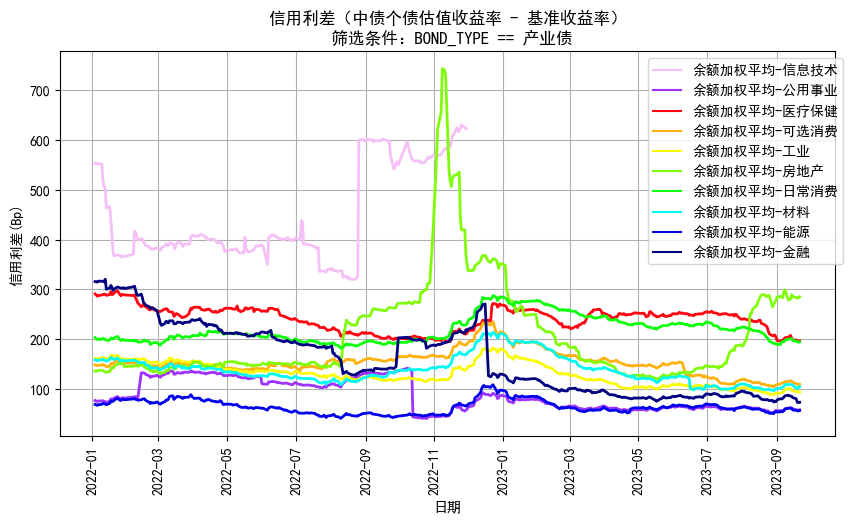

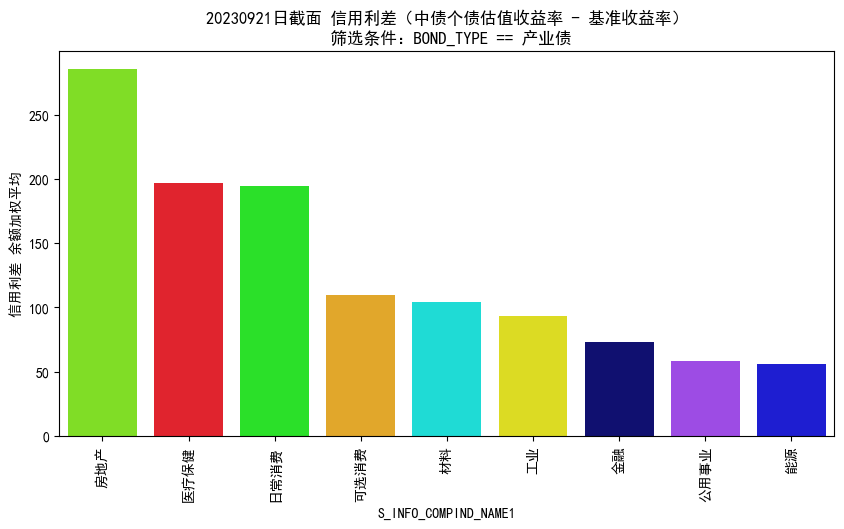

In [30]:
# 时序图像绘制
# 参数
division_label = 'S_INFO_COMPIND_NAME1' # 根据这个字段的类别画线
Filters = [
    ('BOND_TYPE','==','产业债'),
]
CrossSectionConfig = {
    'date':'20230921', # 截面日期
    'plotCrossSection':True, # 是否绘制date时间的柱状截面图
}
# methods 0: 简单平均 1: 中位数 2: 剩余本金加权
BondAnalyzer.plotCreditSpread(
    data=df,
    filters=Filters,
    divisionLabel=division_label,
    methods=[2],
    config=CrossSectionConfig
)

### 个债预警

In [31]:
# Mac 3500个债 约90s Windows较慢 4mins30s
# 债券累计存续时常小于250天不预警
YIELD_CHANGE_PERIOD=7
QUANTILE=0.98
ROLLING_WINDOW=250
ALARM_PERIOD=20
alarmConfig = {
    'TODAY':'20230921' #扫描哪天的存续债
}
ALARMRES = BondAnalyzer.initBondAlarms(
    df,
    YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD, # 累计收益周期
    QUANTILE=QUANTILE, # 预警分位数
    ROLLING_WINDOW=ROLLING_WINDOW, # 历史分位窗口
    ALARM_PERIOD=ALARM_PERIOD, # 预警窗口
    config=alarmConfig
)
df_alarmed_pos_bond = ALARMRES['df_alarmed_pos_bond']
df_alarmed_neg_bond = ALARMRES['df_alarmed_neg_bond']
alarmed_pos_bond_codes = ALARMRES['alarmed_pos_bond_codes']
alarmed_neg_bond_codes = ALARMRES['alarmed_neg_bond_codes']
ALARMED_POS_BONDS = ALARMRES['ALARMED_POS_BONDS']
ALARMED_NEG_BONDS = ALARMRES['ALARMED_NEG_BONDS']

开始检测最近20日出现超越7日累计估值收益变动的绝对值在历史250日内的0.98分位数的20230921债券


100% (3478 of 3478) |####################| Elapsed Time: 0:04:17 Time:  0:04:17


In [32]:
df_alarmed_pos_bond, df_alarmed_neg_bond # 最近突破日期在

(   S_INFO_WINDCODE    最近突破日期  突破时变化程度bp   绝对预警线bp
 0       2080272.IB  20230921     174.68   63.6360
 1        139452.SH  20230921      62.81   50.7628
 2       2080270.IB  20230921      62.81   50.7628
 3        152584.SH  20230921     174.68   63.6360
 4       2080258.IB  20230920      53.56   51.7924
 5       2080257.IB  20230920      81.29   73.4266
 6        152575.SH  20230920      53.56   51.7924
 7        152583.SH  20230920      81.29   73.4266
 8       1826006.IB  20230919      42.29   39.8400
 9       2080281.IB  20230919      45.31   43.8420
 10       152590.SH  20230919      45.31   43.8420
 11       127868.SH  20230918      77.55   63.5906
 12      1880192.IB  20230918      77.55   63.5906
 13       139247.SH  20230915      67.15   57.6874
 14       184556.SH  20230915      64.77   58.5520
 15      1880167.IB  20230915     141.79  141.6234
 16      2280399.IB  20230915      64.77   58.5520
 17      1680395.IB  20230915      67.15   57.6874
 18       139408.SH  20230915  

  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

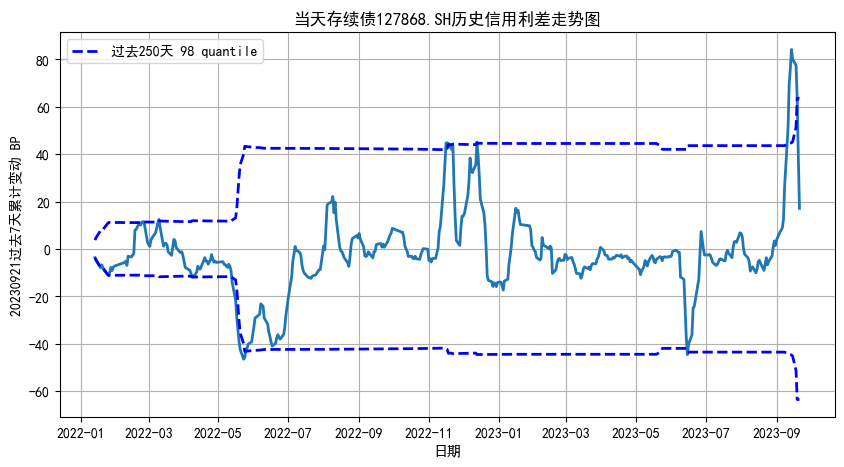

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

ALARM!!!


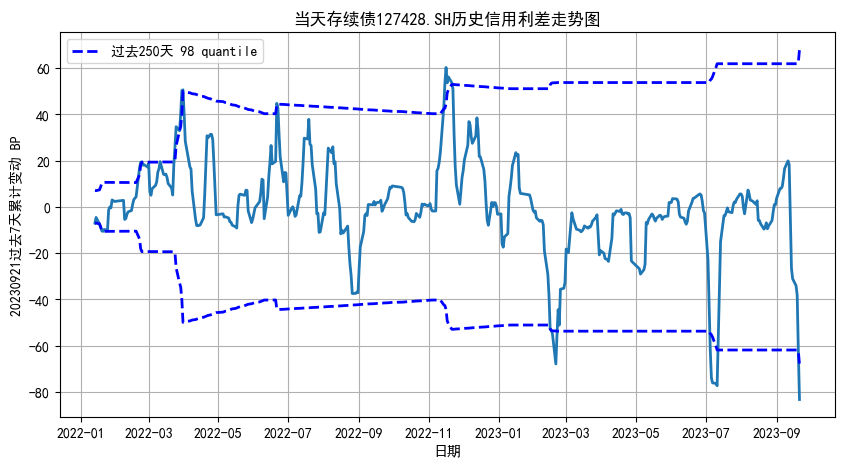

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


ALARM!!!


In [33]:
SHOW_POS_BONDS = list(ALARMED_POS_BONDS.index.unique())[:1]
SHOW_NEG_BONDS = list(ALARMED_NEG_BONDS.index.unique())[:1]
config = {
    'plot':True,
    'plot_abs':False,
}
POS_SUMMARY,_= BondAnalyzer.showSingleBond(
    data=ALARMED_POS_BONDS, 
    bond_codes=SHOW_POS_BONDS,
    YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD, 
    QUANTILE=QUANTILE,
    ROLLING_WINDOW=ROLLING_WINDOW,
    ALARM_PERIOD=ALARM_PERIOD,
    TODAY = '20230921',
    config=config
)
_,NEG_SUMMARY = BondAnalyzer.showSingleBond(
    data=ALARMED_NEG_BONDS, 
    bond_codes=SHOW_NEG_BONDS,
    YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD,
    QUANTILE=QUANTILE,
    ROLLING_WINDOW=ROLLING_WINDOW,
    ALARM_PERIOD=ALARM_PERIOD,
    TODAY = '20230921',
    config=config
)

In [34]:
POS_SUMMARY

,S_INFO_WINDCODE,最近突破日期,突破时变化程度bp,绝对预警线bp
0,127868.SH,20230918,77.55,63.5906


In [35]:
NEG_SUMMARY

,S_INFO_WINDCODE,最近突破日期,突破时变化程度bp,绝对预警线bp
0,127428.SH,20230921,-83.36,68.0816


### 热力图

In [36]:
# 参数 根据哪个字段统计
category = 'S_INFO_COMPIND_NAME2'
# category = ['S_INFO_COMPIND_NAME2','S_INFO_COMPIND_NAME3'] # 数组形式表示字段组合热力图

In [37]:
heatMapConfig = {
    'alarmres':ALARMRES,
    'filters': [
        ('S_INFO_COMPIND_NAME1','==','工业') # 查看细分热力使用
    ],
}
HEATMAP = BondAnalyzer.getHeatMap(df,category,config=heatMapConfig)

数据筛选中...请等待
筛选结果数据量： 28
ALARMED_POS_BONDS_NOW: S_INFO_COMPIND_NAME1 == 工业
存在0条正向突破预警线债券因缺失分类而不考虑进统计数据中
数据筛选中...请等待
筛选结果数据量： 38
ALARMED_NEG_BONDS_NOW: S_INFO_COMPIND_NAME1 == 工业
存在0条反向突破预警线债券因缺失分类而不考虑进统计数据中


In [38]:
HEATMAP['ALARM_PRESSION']

,涨跌比,count,percentageInAlarm
0,+,28,0.424242
1,-,38,0.575758


In [39]:
HEATMAP['ALARM_SUMMARY']

,S_INFO_COMPIND_NAME2,recentChangeDirection,count,percentageInAlarm,percentageInIndustry,industryTotalCount
0,资本货物,+,22,0.785714,0.011659,1887
1,运输,+,4,0.142857,0.014085,284
2,商业和专业服务,+,2,0.071429,0.019417,103
3,资本货物,-,-38,-1.000000,-0.020138,1887
